In [5]:
import mirnylib.numutils 
from multiprocessing import Pool 
import numpy as np 
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

# binning the genomic interval
from mirnylib.numutils import logbinsnew

chainLen = 10000
lbins = logbinsnew(1, chainLen, 1.3)
bins = [(lbins[i], lbins[i + 1]) for i in range(len(lbins) - 1)]
mids_num = np.array([np.sqrt(i[0] * (i[1] - 1)) for i in bins])
print(len(mids_num))

32


In [3]:
def get_error(bins_num, slope_num, der_exp):
    
    # computes the error between numerical and experimental slopes in the region [min_x, max_x]
    # finds the optimal mean loop size yielding the smallest error between the two
        
    # gets the bins and slope variables from the experimental dataframe
    bins = np.array(der_exp['diag.avg'])*1000
    slope = np.array(der_exp['slope'])
        
    # defining the fitting interval
    min_x = 4*10**4
    max_x = 4*10**6

    errors = []
    
    # list of coefficients to multiply the default mean loop size lambda=100kb
    lam_coefs = [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
    
    for lam_coef in lam_coefs:
        
        bins_num_coef = np.copy(bins_num)*lam_coef
        
        # cut out the region from x_min to x_max from the numerical and experimental slopes
        x_num = np.array(bins_num_coef[np.argmax(bins_num_coef >= min_x):np.argmax(bins_num_coef >= max_x)])
        y_num = np.array(slope_num[np.argmax(bins_num_coef >= min_x):np.argmax(bins_num_coef >= max_x)])
        x_exp = np.array(bins[np.argmax(bins >= min_x):np.argmax(bins >= max_x)])
        y_exp = np.array(slope[np.argmax(bins >= min_x):np.argmax(bins >= max_x)])


        # interpolate
        from scipy import interpolate
        f = interpolate.interp1d(x_num, y_num, fill_value="extrapolate")

        y_num = f(x_exp)

        assert len(y_num) == len(y_exp)

        # compute rMSE
        errors.append(np.sqrt(np.sum((y_num-y_exp)**2)/len(y_num)))

    # find the optimal lambda coefficient with the smallest error 
    lam_coef = lam_coefs[np.argmin(errors)]
    
    # repeat the process for the optimal lam_coef
    bins_num_coef = np.copy(bins_num)*lam_coef
    x_num = np.array(bins_num_coef[np.argmax(bins_num_coef >= min_x):np.argmax(bins_num_coef >= max_x)])
    y_num = np.array(slope_num[np.argmax(bins_num_coef >= min_x):np.argmax(bins_num_coef >= max_x)])
    x_exp = np.array(bins[np.argmax(bins >= min_x):np.argmax(bins >= max_x)])
    y_exp = np.array(slope[np.argmax(bins >= min_x):np.argmax(bins >= max_x)])

    from scipy import interpolate
    f = interpolate.interp1d(x_num, y_num, fill_value="extrapolate")

    y_num = f(x_exp)

    assert len(y_num) == len(y_exp)

    error = np.sqrt(np.sum((y_num-y_exp)**2)/len(y_num))

    return x_num, y_num, x_exp, y_exp, error, lam_coef


0.03457796046093531
1.3


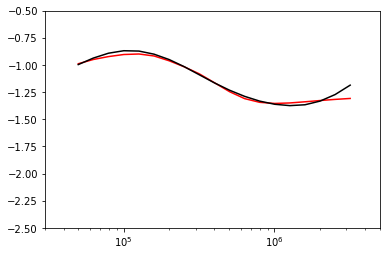

In [6]:
# example

#der_exp = pickle.load(open('C_data_derivatives/U54-HFFc64DN-FA-DSG-MNase-R1.pickle', "rb"))
der_exp = pickle.load(open('U54-HFFc64DN-FA-DSG-MNase-R1.pickle', "rb"))
with open(f'../loops_on_ring/num_pickles/prod_ders/H_h_04_l100_d100_1.pickle', 'rb') as f:
    der = gaussian_filter1d(pickle.load(f),1)

x_num, y_num, x_exp, y_exp, error, lam_coef = get_error(mids_num[1:]*1000, der, der_exp)
print(error)
print(lam_coef)
plt.plot(x_exp, y_num, color='r')
plt.plot(x_exp, y_exp, color='k')
plt.xscale('log')
plt.ylim([-2.5, -0.5])
plt.xlim([3*10**4, 5*10**6])
    
plt.show()

In [ ]:
import seaborn as sns

#experimental dataframe with P(s) in 1kb resolution
der_exp = pickle.load(open(f'U54-HFFc64DN-FA-DSG-MNase-R1.pickle', "rb"))
slope = np.array(der_exp['slope'])
bins = np.array(der_exp['diag.avg'])

# parameters
# list of Hurst parameters corresponds 
Hhs = ['05', '045', '04', '035', '03']
ds = [200, 100, 50, 30, 20]
lgs = [0.5, 1, 2, 3, 5]
lps = [1, 15, 2, 25, 3, 35, 4]
lps_true = [1, 1.5, 2, 2.5, 3, 3.5, 4]
slopes_av = [-1.5, -1.4, -1.3, -1.2, -1.1]

errors = np.ones((len(Hhs),len(ds),len(lps)))
lam_coefs = np.ones((len(Hhs),len(ds),len(lps)))

for i in range(len(Hhs)):
    for j in range(len(ds)):
        for k in range(len(lps)):
            
            Hh = Hhs[i]
            d = ds[j]
            lp = lps[k]
            
            sigma_filt = 1

            with open(f'../loops_on_ring/num_pickles/prod_ders/H_h_{Hh}_l100_d{d}_{lp}.pickle', 'rb') as f:
                der = gaussian_filter1d(pickle.load(f),sigma_filt)
            
            x_num, y_num, x_exp, y_exp, error, lam_coef = get_error(mids_num[1:]*1000, der, der_exp)

            errors[i,j,k] = error
            lam_coefs[i,j,k] = lam_coef
                
                
print('Done!')

fig, ax = plt.subplots(3, 5, figsize = (5*7,5*3))
x_axis_labels = [1, 1.5, 2, 2.5, 3, 3.5, 4]
y_axis_labels = np.array([0.5, 1, 2, 3, 5], dtype=float)

for j in range(5):


    errors1 = np.copy(errors)
    
    a = np.where(errors1[j, :, :]==np.min(errors1[j, :, :]))[0][0]
    b = np.where(errors1[j, :, :]==np.min(errors1[j, :, :]))[1][0]
    d1 = ds[a]
    lp1_true = lps_true[b]
    lp1 = lps[b]
    lam_coef1 = lam_coefs[j, a, b]
    er1 = errors[j, a, b]
    errors1[j,a,b] = 100

    a = np.where(errors1[j, :, :]==np.min(errors1[j, :, :]))[0][0]
    b = np.where(errors1[j, :, :]==np.min(errors1[j, :, :]))[1][0]
    d2 = ds[a]
    lp2_true = lps_true[b]
    lp2 = lps[b]
    lam_coef2 = lam_coefs[j, a, b]
    er2 = errors[j, a, b]
    errors1[j,a,b] = 100

    a = np.where(errors1[j, :, :]==np.min(errors1[j, :, :]))[0][0]
    b = np.where(errors1[j, :, :]==np.min(errors1[j, :, :]))[1][0]
    d3 = ds[a]
    lp3_true = lps_true[b]
    lp3 = lps[b]
    lam_coef3 = lam_coefs[j, a, b]
    er3 = errors[j, a, b]
    errors1[j,a,b] = 100
    

    ax[0,j].plot(bins*1000, gaussian_filter1d(slope,0.1), color='k', linewidth=3)
    
    with open(f'../loops_on_ring/num_pickles/prod_ders/H_h_{Hhs[j]}_l100_d{d1}_{lp1}.pickle', 'rb') as f:
        der_num1 = gaussian_filter1d(pickle.load(f),1)
    ax[0,j].plot(mids_num[1:]*1000*lam_coef1, der_num1, color='r', alpha=1, linewidth=3, \
                     label=f'l/g={lgs[ds.index(d1)]}, lp={lp1_true}, l={int(lam_coef1*100)}kb')
    
    with open(f'../loops_on_ring/num_pickles/prod_ders/H_h_{Hhs[j]}_l100_d{d2}_{lp2}.pickle', 'rb') as f:
        der_num2 = gaussian_filter1d(pickle.load(f),1)
    ax[0,j].plot(mids_num[1:]*1000*lam_coef2, der_num2, color='m', alpha=1, linewidth=3, \
                     label=f'l/g={lgs[ds.index(d2)]}, lp={lp2_true}, l={int(lam_coef2*100)}kb')
    
    with open(f'../loops_on_ring/num_pickles/prod_ders/H_h_{Hhs[j]}_l100_d{d3}_{lp3}.pickle', 'rb') as f:
        der_num3 = gaussian_filter1d(pickle.load(f),1)
    ax[0,j].plot(mids_num[1:]*1000*lam_coef3, der_num3, color='y', alpha=1, linewidth=3, \
                     label=f'l/g={lgs[ds.index(d3)]}, lp={lp3_true}, l={int(lam_coef3*100)}kb')
    
    lav = int(100*(lam_coef1+lam_coef2+lam_coef3)/3)
    ax[0,j].plot(mids_num[1:]*lav, np.ones(len(mids_num[1:]))*slopes_av[j], color='k', linewidth=0.5)
    ax[0,j].set_title(f'err={(int(100*er1))/100}-{(int(100*er3))/100}', fontsize=30)
    ax[0,j].set_xscale('log')
    ax[0,j].set_ylim([-2.5, -0.5])
    ax[0,j].set_xlim([4*10**4, 5*10**6])
    ax[0,j].legend(fontsize=25)
    
    
    sns.heatmap(errors[j, :, :], vmin=0, vmax=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[1,j])
    sns.heatmap(np.array(lam_coefs[j, :, :]*100, dtype=int), vmin=50, vmax=300, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[2,j])
            

for i in range(3):
    for j in range(5):
        ax[i,j].tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()

#plt.savefig("scaled_curves_numerics.pdf", transparent=True)

plt.show()

